In [1]:
import numpy as np
import twitter, re, datetime, pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingClassifier

# Tweet Prediction

- The intention is the ability to identify the probability where these information originated from or who is more likely to produce that content. The project explores the problem on a smaller scale between two opposing sides. Also, it implements the possibility to explore this practice on a larger scale analyzing bigger entities like governments and organization, and to be able to distinguish if particular pieces of information are produced a particular side to prevent information fraud, deceit, or deception

- The project will use Python wrapper by Twitter Application Programming Interface (API) to mine tweets from the selected users, in order to create a dataframe. Then will use a TfidfVectorizer (natural language processing) from sklearn to analyze the tweets from each user. After cleaning the texts and exploring it, multiple ML algorithms will be used like Linear regression , Logistic Regression, SVM , Decision trees , and other applicable ones.

- It will be later trained and fitted for optimization, and then evaluated through a confusion matrix. Finally, create a function to take a specific row from the dataframe to predict to which user it belongs, witha prediction result (either candidate A or B).

#### [1] Setup Twitter API
#### [2] Establishing Class
#### [3] Create Training Data
#### [4] Using Textacy to pre-process tweets
#### [5] Building Model
#### [6] Highest probablity tweet and Prediction module

___
# [1] Setup Twitter API

##### This will be done on the following steps
- 1. Setup API keys
- 2. Test function by using **@JoeBiden** account
- 3. Print results
- 4. Setup TweetMiner function
___

In [2]:
# Taken from Mike Taylor A Python wrapper around the Twitter API.
# https://github.com/bear/python-twitter

twitter_keys = {
    'consumer_key':        'L4sziHBqV4VUIfKezbos0JMVl',
    'consumer_secret':     'lJau6R7GIHFwoGR5wB3PlLQPXBChwzJFJ9WGXXtazcDSA1Vb1X',
    'access_token_key':    '941359629606539264-05XcmQfdwMXTbPNWS3r7cZThvbQBxCK',
    'access_token_secret': 'VdE3VJVk6oxbohQGcw7WYA5Tg4Sr8kW9duTO1wxmB6qXk'
}

api = twitter.Api(
    consumer_key         =   twitter_keys['consumer_key'],
    consumer_secret      =   twitter_keys['consumer_secret'],
    access_token_key     =   twitter_keys['access_token_key'],
    access_token_secret  =   twitter_keys['access_token_secret'],
    tweet_mode = 'extended'
)

# double check if the API is working

type(api)

twitter.api.Api

#### Testing function

In [3]:
# There is a limit set on the count by Twitter API, can't exceed 200
# Link with the highlighted text
# https://tinyurl.com/y3cx3m6a

# A first test trial to check everything is working. We are using Joe Biden's Account
# https://twitter.com/JoeBiden

x = api.GetUserTimeline(screen_name="JoeBiden", count=5, include_rts=False)
x = [_.AsDict() for _ in x]

x[0]

{'created_at': 'Tue Dec 08 13:56:00 +0000 2020',
 'favorite_count': 14348,
 'full_text': 'There has never been anyone more qualified to be Treasury Secretary than Janet Yellen. Period.\n\nI trust her knowledge and look forward to working with her to build our economy back better. https://t.co/M7E31FPimX',
 'hashtags': [],
 'id': 1336308549262200832,
 'id_str': '1336308549262200832',
 'lang': 'en',
 'quoted_status': {'created_at': 'Mon Dec 07 22:14:48 +0000 2020',
  'favorite_count': 6657,
  'full_text': 'Our mission is to restore economic prosperity and financial stability.\n\nWe’ll do that by pursuing an investment agenda to rebuild our infrastructure, create better jobs, advance racial equity, and fight the climate crisis. https://t.co/IDUKBlcFDs',
  'hashtags': [],
  'id': 1336071689583665152,
  'id_str': '1336071689583665152',
  'lang': 'en',
  'media': [{'display_url': 'pic.twitter.com/IDUKBlcFDs',
    'expanded_url': 'https://twitter.com/JanetYellen/status/1336071689583665152/vid

In [4]:
# As you can see we get a list of information about each tweet
# We want to print the tweet text and tweet ID


for element in x:
    print(element['id'])
    print(element['full_text'])
    print('____________________________')

1336308549262200832
There has never been anyone more qualified to be Treasury Secretary than Janet Yellen. Period.

I trust her knowledge and look forward to working with her to build our economy back better. https://t.co/M7E31FPimX
____________________________
1336128110203449345
Paul Sarbanes and I served together on the Foreign Relations Committee for 30 years. There was no one sharper, more committed, or with firmer principles. And he, too, returned to his family nearly every night. They meant the world to him.

Rest In Peace, Paul. https://t.co/tzekdNb74b
____________________________
1336054123163234304
Today, we remember those we lost at Pearl Harbor 79 years ago — and we salute those who answered duty’s call with strength and courage. Our nation owes an incredible debt to those who have served and must ensure they and their families receive the care they’ve earned.
____________________________
1336003791183818753
Dr. Fauci isn't just one of our foremost experts on combating viru

In [5]:
# We could call the Tweet ID

print(type(x[0]))
x[0]['id']

<class 'dict'>


1336308549262200832

#### TweetMiner

In [6]:
#TweetMiner function from Bhishan Poudel and Mike Roman

class TweetMiner(object):

    
    def __init__(self, api, result_limit = 200):
        
        self.api = api        
        self.result_limit = result_limit
        

    def mine_user_tweets(self, user="Joebiden", mine_retweets=False, max_pages=20):

        data           =  []
        last_tweet_id  =  False
        page           =  1
        
        while page <= max_pages:
            
            if last_tweet_id:
                statuses   =   self.api.GetUserTimeline(screen_name=user, count=self.result_limit, max_id=last_tweet_id - 1, include_rts=mine_retweets)
                statuses = [ _.AsDict() for _ in statuses]
            else:
                statuses   =   self.api.GetUserTimeline(screen_name=user, count=self.result_limit, include_rts=mine_retweets)
                statuses = [_.AsDict() for _ in statuses]
                
            for item in statuses:
                # Using try except here.
                # When retweets = 0 we get an error (GetUserTimeline fails to create a key, 'retweet_count')
                try:
                    mined = {
                        'tweet_id':        item['id'],
                        'handle':          item['user']['screen_name'],
                        'retweet_count':   item['retweet_count'],
                        'text':            item['full_text'],
                        'mined_at':        datetime.datetime.now(),
                        'created_at':      item['created_at'],
                    }
                
                except:
                        mined = {
                        'tweet_id':        item['id'],
                        'handle':          item['user']['screen_name'],
                        'retweet_count':   0,
                        'text':            item['full_text'],
                        'mined_at':        datetime.datetime.now(),
                        'created_at':      item['created_at'],
                    }
                
                last_tweet_id = item['id']
                data.append(mined)
                
            page += 1
            
        return data

# [2] Establishing Class
### ---------------------------
##### This will be done on the following steps 
- 1. Setup result limit (200) on TweetMiner
- 2. Mine **@JoeBiden** tweets
- 3. Mine **@realDonaldTrump** tweets
- 4. Print results
- 5. Convert output tweets to a pandas dataframe

In [7]:
# Creating a limit of 200 - Complying with rate limit request

miner = TweetMiner(api, result_limit=300)

In [8]:
# Creating the two classes

biden = miner.mine_user_tweets(user="Joebiden")
donald = miner.mine_user_tweets(user="realDonaldTrump")

In [9]:
# Printing the first 5 tweets to see our results for Biden

for x in range(5):
    print(biden[x]['text'])
    print('---')

There has never been anyone more qualified to be Treasury Secretary than Janet Yellen. Period.

I trust her knowledge and look forward to working with her to build our economy back better. https://t.co/M7E31FPimX
---
Paul Sarbanes and I served together on the Foreign Relations Committee for 30 years. There was no one sharper, more committed, or with firmer principles. And he, too, returned to his family nearly every night. They meant the world to him.

Rest In Peace, Paul. https://t.co/tzekdNb74b
---
Today, we remember those we lost at Pearl Harbor 79 years ago — and we salute those who answered duty’s call with strength and courage. Our nation owes an incredible debt to those who have served and must ensure they and their families receive the care they’ve earned.
---
Dr. Fauci isn't just one of our foremost experts on combating viruses—he is a good man and a tireless public servant. He has served six presidents and led us through some of our toughest challenges.

Our administration, a

In [10]:
# Printing the first 10 tweets to see our results for Donald

for x in range(10):
    print(donald[x]['text'])
    print('--')

...And it’s not normal when a sitting Senator is forced to retire because his Arizona poll numbers were so low that he would have come out dead last in the Republican Primary, and had zero chance of winning the general election. Great job Jeff! https://t.co/5kbOQIpstq
--
I hope House Republicans will vote against the very weak National Defense Authorization Act (NDAA), which I will VETO. Must include a termination of Section 230 (for National Security purposes), preserve our National Monuments, &amp; allow for 5G &amp; troop reductions in foreign lands!
--
Georgia is watching @BrianKempGA, @GeoffDuncanGA, and @GaSecofState! https://t.co/8R8rH8aV9U
--
https://t.co/reenwuelHY
--
THANK YOU GEORGIA! https://t.co/62s0XaiYPI
--
Georgia Lt. Governor @GeoffDuncanGA is a RINO Never Trumper who got himself elected as LG by falsely claiming to be “pro-Trump”. Too dumb or corrupt to recognize massive evidence of fraud in GA &amp; should be replaced! We need every great Georgian to call him out! #S


#### Testing to see how the dataframe looks
#### Joe Biden

In [11]:
# Taking the tweets output from tweetminer and converting it into a pandas dataframe
# A: Joe Biden

pd.DataFrame(biden).head(10)

,tweet_id,handle,retweet_count,text,mined_at,created_at
0,1336308549262200832,JoeBiden,1328,There has never been anyone more qualified to ...,2020-12-08 09:45:50.544717,Tue Dec 08 13:56:00 +0000 2020
1,1336128110203449345,JoeBiden,1976,Paul Sarbanes and I served together on the For...,2020-12-08 09:45:50.545715,Tue Dec 08 01:59:00 +0000 2020
2,1336054123163234304,JoeBiden,9744,"Today, we remember those we lost at Pearl Harb...",2020-12-08 09:45:50.545715,Mon Dec 07 21:05:00 +0000 2020
3,1336003791183818753,JoeBiden,13261,Dr. Fauci isn't just one of our foremost exper...,2020-12-08 09:45:50.545715,Mon Dec 07 17:45:00 +0000 2020
4,1335989451584118790,JoeBiden,11806,Georgia — Today is your last day to register t...,2020-12-08 09:45:50.545715,Mon Dec 07 16:48:01 +0000 2020
5,1335964029299224578,JoeBiden,3883,This team of world-class medical experts and p...,2020-12-08 09:45:50.545715,Mon Dec 07 15:07:00 +0000 2020
6,1335758425284874240,JoeBiden,15690,I promise you this: I will spare no effort — o...,2020-12-08 09:45:50.545715,Mon Dec 07 01:30:00 +0000 2020
7,1335690479351042057,JoeBiden,6671,The dreams of too many Americans have been def...,2020-12-08 09:45:50.545715,Sun Dec 06 21:00:00 +0000 2020
8,1335619257376247811,JoeBiden,9768,"With COVID-19 cases rising across the nation, ...",2020-12-08 09:45:50.545715,Sun Dec 06 16:17:00 +0000 2020
9,1335392513364922370,JoeBiden,9691,"I know times are tough, the challenges are dau...",2020-12-08 09:45:50.545715,Sun Dec 06 01:16:00 +0000 2020


#### Donald Trump

In [12]:
# B: Donald Trump
pd.DataFrame(donald).head(10)

,tweet_id,handle,retweet_count,text,mined_at,created_at
0,1336320843484286977,realDonaldTrump,485,...And it’s not normal when a sitting Senator ...,2020-12-08 09:46:00.598633,Tue Dec 08 14:44:51 +0000 2020
1,1336318760106471424,realDonaldTrump,4346,I hope House Republicans will vote against the...,2020-12-08 09:46:00.598633,Tue Dec 08 14:36:34 +0000 2020
2,1336177638528983041,realDonaldTrump,19322,"Georgia is watching @BrianKempGA, @GeoffDuncan...",2020-12-08 09:46:00.598633,Tue Dec 08 05:15:48 +0000 2020
3,1336161955845959680,realDonaldTrump,38569,https://t.co/reenwuelHY,2020-12-08 09:46:00.598633,Tue Dec 08 04:13:29 +0000 2020
4,1336150611889426433,realDonaldTrump,25781,THANK YOU GEORGIA! https://t.co/62s0XaiYPI,2020-12-08 09:46:00.598633,Tue Dec 08 03:28:25 +0000 2020
5,1336148836495069185,realDonaldTrump,32010,Georgia Lt. Governor @GeoffDuncanGA is a RINO ...,2020-12-08 09:46:00.598633,Tue Dec 08 03:21:21 +0000 2020
6,1336122354003537921,realDonaldTrump,30755,“Georgia is not the only state that pushed thr...,2020-12-08 09:46:00.598633,Tue Dec 08 01:36:07 +0000 2020
7,1336114633485266944,realDonaldTrump,30042,Mail-In rejection rate was minuscule compared ...,2020-12-08 09:46:00.598633,Tue Dec 08 01:05:27 +0000 2020
8,1336113603116752897,realDonaldTrump,28846,State officials were ignorant of the limitatio...,2020-12-08 09:46:00.598633,Tue Dec 08 01:01:21 +0000 2020
9,1336112582424473600,realDonaldTrump,31996,"“These actions on the part of State Officials,...",2020-12-08 09:46:00.598633,Tue Dec 08 00:57:18 +0000 2020



___
# [3] Create Training Data

##### This will be done on the following steps

- 1. Convert Tweets output into a dataframe
- 2. Merge two dataframes into one
- 3. Check ngrams to see interesting word count
```
____________________________________________________________________________________________________


#### Joe Biden

In [13]:
# Tweetminer
# Max pages=8 because to have almost equal shapes

biden_tweets = miner.mine_user_tweets("Joebiden")

# Converting to dataframe

biden_df = pd.DataFrame(biden_tweets)
print (biden_df.shape)

(3039, 6)


#### Donald Trump

In [14]:
# Tweetminer

trump_tweets = miner.mine_user_tweets("realDonaldTrump")

# Converting to dataframe

trump_df = pd.DataFrame(trump_tweets)
trump_df.shape

(1991, 6)

#### Merging the two dataframes into one

In [15]:
# Biden + Trump dataframe
# We're calling the data "tweets"

tweets = pd.concat([trump_df, biden_df], axis=0).reset_index(drop=True)
tweets.shape

(5030, 6)

#### Checking the n-grams to see interesting information

In [56]:
class color:
   
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

# Using TfidfVectorizer to find ngrams
# Range = how many words in a sentence

# 2-4 words
vect = TfidfVectorizer(ngram_range=(2,5), stop_words='english')
# 1 words
vect2 = TfidfVectorizer(ngram_range=(1,4), stop_words='english')

# Converting all Trump tweets into one string

com_words = "".join(trump_df['text'])
ngrams_sum = vect.build_analyzer()(com_words)
ngrams_sum2 = vect2.build_analyzer()(com_words)

print(color.BOLD + color.RED+"Two to Four word sentence"+ color.END)
print(Counter(ngrams_sum).most_common(6))
print("___________")
print(color.BOLD + color.RED+"One word"+ color.END)
print(Counter(ngrams_sum2).most_common(6))

Two to Four word sentence
[('joe biden', 104), ('maga https', 81), ('second amendment', 60), ('fake news', 58), ('total endorsement', 57), ('sleepy joe', 56)]
___________
One word
[('https', 1013), ('biden', 301), ('great', 252), ('vote', 243), ('amp', 207), ('election', 186)]


In [18]:
# Using TfidfVectorizer to find ngrams
# Range = how many words in a sentence

# 2-4 words
vect = TfidfVectorizer(ngram_range=(2,5), stop_words='english')
# 1 words
vect2 = TfidfVectorizer(ngram_range=(1,4), stop_words='english')

# Converting all Trump tweets into on string
com_words = "".join(biden_df['text'])
ngrams_sum = vect.build_analyzer()(com_words)
ngrams_sum2 = vect2.build_analyzer()(com_words)

print(color.BOLD + color.RED+"Two to Four word sentence"+ color.END)
print(Counter(ngrams_sum).most_common(6))
print("___________")
print(color.BOLD + color.RED+"One word"+ color.END)
print(Counter(ngrams_sum2).most_common(6))

Two to Four word sentence
[('donald trump', 453), ('covid 19', 184), ('president trump', 139), ('health care', 120), ('american people', 112), ('white house', 110)]
___________
One word
[('https', 2309), ('trump', 803), ('president', 734), ('donald', 454), ('donald trump', 453), ('need', 422)]


___
# [4] Using Textacy to pre-process tweets

##### This will be done on the following steps
- 1. Extract Tweets column as a text list
- 2. Use **Textacy** to pre-process tweets
```
____

In [19]:
from textacy import preprocessing as tp
from textacy import vsm
import textacy as textacy

In [20]:
# More information about textacy
# https://github.com/chartbeat-labs/textacy

# Text Pre-processing commands and documentation
# https://textacy.readthedocs.io/en/stable/api_reference/text_processing.html

In [21]:
# Use textacy to Pre-process text with following functions

# 1. Replace all Urls
# 2. Remove all accents
# 3. Replace Emojis
# 4. Replace Currency symbols
# 5. Replace hashtags
# 6. Replace Phone numbers
# 7. Remove punctuations "!@-—=+#$%’^&*)(/\;:.,~`"
# 8. Normalize unicode characters in text into canonical forms.

# We want to make sure we pass arguments to maintain API and Dict
# Converting tweet column from dataframe into a list

tweet_text=tweets['text'].values.tolist()

# Pre-process

clean_text=[tp.normalize.normalize_unicode(tp.remove.remove_punctuation(tp.replace.replace_phone_numbers
                              (tp.replace.replace_hashtags
                               (tp.replace_currency_symbols
                                (tp.replace.replace_emojis
                                 (tp.remove.remove_accents
                                  (tp.replace.replace_urls(x)))))), marks='?!@-—=+#$%’^&*)(/\;:.,~`'))for x in tweet_text]

In [22]:
# Checking if it's a list
# Cleaned Text

print(clean_text[8])
type(clean_text)

State officials were ignorant of the limitations imposed by the Constitution  Ken Starr


list

In [23]:
# Original Text

print(tweet_text[8])
type(tweet_text)

State officials were ignorant of the limitations imposed by the Constitution. Ken Starr


list

___
# [5] Building Model

##### This will be done on the following steps 
- 1. Create a target
- 2. TF IDF Vectorizer to vectorize text
- 3. Split training and test data
- 4. TF IDF Vectorizer to vectorize text
- 5. Grid search paramaters
- 6. Create a pipeline with multiple models 
- 7. Bagging classifier
- 8. Voting classifier
```
____

In [24]:
# creating target

y = tweets['handle'].map(lambda x: 1 if x == 'realDonaldTrump' else 0).values
print(max(pd.Series(y).value_counts(normalize=True)))

0.6041749502982108


In [25]:
from sklearn.preprocessing import LabelEncoder

# Using label Encoder for the target

le = LabelEncoder()
y2=le.fit_transform(tweets['handle'].values)

___
___

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer


# TF IDF Vectorizer to vectorize text

tfv = TfidfVectorizer(ngram_range=(2,4), max_features=4993)
cvec = CountVectorizer(ngram_range=(2,4), max_features=4993)
X = tfv.fit_transform(clean_text).todense()
X2= cvec.fit_transform(clean_text)

print (X2.shape)

(5030, 4993)


In [27]:
print (y2.shape)

(5030,)


___
___

#### Split data to train and test

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.50,random_state=0)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2515, 4993), (2515,), (2515, 4993), (2515,))

#### Hyperparameter

In [66]:
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression()
params = {'penalty': ['l1', 'l2'], 'C':np.logspace(-5,0,100)}
#Grid searching
gs = GridSearchCV(lr, param_grid=params, cv=5, verbose=0,n_jobs=1)
gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=1,
             param_grid={'C': array([1.00000000e-05, 1.12332403e-05, 1.26185688e-05, 1.41747416e-05,
       1.59228279e-05, 1.78864953e-05, 2.00923300e-05, 2.25701972e-05,
       2.53536449e-05, 2.84803587e-05, 3.19926714e-05, 3.59381366e-05,
       4.03701726e-05, 4.53487851e-05, 5.09413801e-05, 5.72236766e-05,
       6.42807312e-05, 7.22080902e-05...
       6.89261210e-02, 7.74263683e-02, 8.69749003e-02, 9.77009957e-02,
       1.09749877e-01, 1.23284674e-01, 1.38488637e-01, 1.55567614e-01,
       1.74752840e-01, 1.96304065e-01, 2.20513074e-01, 2.47707636e-01,
       2.78255940e-01, 3.12571585e-01, 3.51119173e-01, 3.94420606e-01,
       4.43062146e-01, 4.97702356e-01, 5.59081018e-01, 6.28029144e-01,
       7.05480231e-01, 7.92482898e-01, 8.90215085e-01, 1.00000000e+00]),
                         'penalty': ['l1', 'l2']})

In [67]:
print (gs.best_params_)
print (gs.best_score_)

{'C': 1.0, 'penalty': 'l2'}
0.909741550695825


In [31]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(LogisticRegression(), X_train, y_train, cv=3)

print (accuracies.mean())
print (1-y_train.mean())

0.87075997773612
0.6075546719681908


___
___

#### Pipeline

In [32]:
## Pipelines Creation
## 1. Data Preprocessing by using Standard Scaler
## 2. Apply  Classifier

In [33]:
pipeline_lr=Pipeline([('lr_classifier',LogisticRegression(random_state=42))])

In [34]:
pipeline_dt=Pipeline([('dt_classifier',DecisionTreeClassifier())])

In [35]:
pipeline_randomforest=Pipeline([('rf_classifier',RandomForestClassifier())])

In [36]:
pipeline_svm=Pipeline([('svc_classifier',SVC())])

In [37]:
pipeline_xgb=Pipeline([('xgb_classifier',GradientBoostingClassifier(n_estimators=100, learning_rate=1,
                      max_depth=3, random_state=42))])

#### List of pipelines

In [38]:
## list of pipelines
pipelines = [pipeline_lr, pipeline_dt, pipeline_randomforest, pipeline_svm, pipeline_xgb]

In [39]:
best_accuracy=0.0
best_classifier=0
best_pipeline=""

In [40]:
## Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Logistic Regression', 1: 'Decision Tree', 2: 'RandomForest', 3: 'SVM', 4:'xgb'}

## Fit the pipelines

for pipe in pipelines:
	pipe.fit(X_train, y_train)

#### Pipeline results

In [41]:
for i,model in enumerate(pipelines):
    print("{} Test Accuracy: {}".format(pipe_dict[i],model.score(X_test,y_test)))

Logistic Regression Test Accuracy: 0.9113320079522863
Decision Tree Test Accuracy: 0.8429423459244533
RandomForest Test Accuracy: 0.8799204771371769
SVM Test Accuracy: 0.8890656063618291
xgb Test Accuracy: 0.8500994035785289


In [42]:
class color:
   
   RED = '\033[91m'
   BOLD = '\033[1m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'

for i,model in enumerate(pipelines):
    if model.score(X_test,y_test)>best_accuracy:
        best_accuracy=model.score(X_test,y_test)
        best_pipeline=model
        best_classifier=i
print(color.BOLD + color.BLUE+'Classifier with best accuracy:{}'.format(pipe_dict[best_classifier]))

Classifier with best accuracy:Logistic Regression


#### Bagging classifier

In [43]:
from sklearn.ensemble import BaggingClassifier
bagging = BaggingClassifier(pipeline_lr)

In [44]:
bagging.fit(X_train, y_train)

BaggingClassifier(base_estimator=Pipeline(steps=[('lr_classifier',
                                                  LogisticRegression(random_state=42))]))

In [45]:
bagging.score(X_test, y_test)

0.9057654075546719

#### Voting classifier

In [47]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

clf1 = pipeline_lr
clf2 = pipeline_dt
clf3 = pipeline_randomforest
clf4 = pipeline_svm
clf5 = pipeline_xgb

eclf = VotingClassifier(
    estimators=[('lr', clf1), ('dt', clf2), ('rf', clf3), ('svm', clf4), ('gbc', clf5)],)

for clf, label in zip([clf1, clf2, clf3, clf4, clf5, eclf], ['Logistic Regression', 'Decision Tree', 'RandomForest', 'SVM', 'GradientBoostingClassifier', 'Ensemble']):
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
    print(color.BOLD + color.BLUE+"Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.91 (+/- 0.02) [Logistic Regression]
Accuracy: 0.85 (+/- 0.02) [Decision Tree]
Accuracy: 0.88 (+/- 0.03) [RandomForest]
Accuracy: 0.90 (+/- 0.02) [SVM]
Accuracy: 0.85 (+/- 0.02) [GradientBoostingClassifier]
Accuracy: 0.89 (+/- 0.02) [Ensemble]


#### We are going to use Logistic Regression

___
# [6] Highest probablity tweet and Prediction module

##### This will be done on the following steps
- 1. Testing a prediction module
- 2. Create a prediction function
- 3. See tweet with highest probability from Biden
- 4. See tweet with highest probability from Trump
___

In [48]:
# Fitting into LR

estimator = LogisticRegression(penalty='l2',C=1)
estimator.fit(X,y2)

# Testing TfIdf vectors with copied tweets
# First is from Biden

source_test = [
    "Paul Sarbanes and I served together on the Foreign Relations Committee for 30 years. There was no one sharper, more committed, or with firmer principles. And he, too, returned to his family nearly every night. They meant the world to him.Rest In Peace, Paul.",
]


# Printing results

Xtest = tfv.transform(source_test)
ac=pd.DataFrame(estimator.predict_proba(Xtest), columns=["Proba_Biden", "Proba_Trump"])
ac

,Proba_Biden,Proba_Trump
0,0.768084,0.231916


In [49]:
estimator.predict_proba(X_test)

array([[0.82631523, 0.17368477],
       [0.82923373, 0.17076627],
       [0.55022047, 0.44977953],
       ...,
       [0.81040594, 0.18959406],
       [0.8110458 , 0.1889542 ],
       [0.78267278, 0.21732722]])

#### Prediction Function

In [74]:
# Creating a prediction function
# You could a paste a text from a tweet by either candidates and the module will predict to whom it belongs

def predict_text() :
    
    print(color.BOLD +'"PASTE TWEET TEXT HERE"'+ color.END)
    in_no = [input()]
    
    
    # Text Preprocess
    
    cleaning=[tp.normalize.normalize_unicode(tp.remove.remove_punctuation(tp.replace.replace_phone_numbers
                              (tp.replace.replace_hashtags
                               (tp.replace_currency_symbols
                                (tp.replace.replace_emojis
                                 (tp.remove.remove_accents
                                  (tp.replace.replace_urls(x)))))), marks='?!@-—=+#$%’^&*)(/\;:.,~`'))for x in in_no]
    #
    
    Xtest1 = tfv.transform(cleaning)
    pr=pd.DataFrame(estimator.predict_proba(Xtest1), columns=["Proba_Biden", "Proba_Trump"])
    
    # Plotting a bar chart
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,0.5,0.5])
    cand = ['Proba_Biden', 'Proba_Trump']
    probabilty = [float(pr['Proba_Biden']*100),float(pr['Proba_Trump']*100)]
    ax.bar(cand,probabilty)
    plt.show()
    
    # Print Answer
    
    if min(pr) == 'Proba_Biden' :
        print(color.BOLD + color.BLUE +"THIS TWEET IS PROBABLY BY **JOE BIDEN**"+ color.END)
    else:
        print (color.BOLD + color.RED +"THIS TWEET IS PROBABLY BY **DONALD TRUMP**"+ color.END)


"PASTE TWEET TEXT HERE"


   All Donald Trump can see from Park Avenue is Wall Street.  He thinks the economy is doing well if the Dow Jones is doing well.  Believe it or not, Mr. President, most Americans don't live off the stock market.


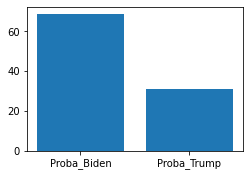

THIS TWEET IS PROBABLY BY **JOE BIDEN**


In [75]:
predict_text()

___
___

#### Most probable tweet from both candidates 

In [61]:
Probas_x = pd.DataFrame(estimator.predict_proba(X_test), columns=["Proba_Biden", "Proba_Donald"])
joined_x = pd.merge(tweets, Probas_x, left_index=True, right_index=True)
joined_x.head(5)

,tweet_id,handle,retweet_count,text,mined_at,created_at,Proba_Biden,Proba_Donald
0,1336320843484286977,realDonaldTrump,638,...And it’s not normal when a sitting Senator ...,2020-12-08 09:46:15.616898,Tue Dec 08 14:44:51 +0000 2020,0.826315,0.173685
1,1336318760106471424,realDonaldTrump,4442,I hope House Republicans will vote against the...,2020-12-08 09:46:15.616898,Tue Dec 08 14:36:34 +0000 2020,0.829234,0.170766
2,1336177638528983041,realDonaldTrump,19332,"Georgia is watching @BrianKempGA, @GeoffDuncan...",2020-12-08 09:46:15.616898,Tue Dec 08 05:15:48 +0000 2020,0.550220,0.449780
3,1336161955845959680,realDonaldTrump,38584,https://t.co/reenwuelHY,2020-12-08 09:46:15.616898,Tue Dec 08 04:13:29 +0000 2020,0.878435,0.121565
4,1336150611889426433,realDonaldTrump,25785,THANK YOU GEORGIA! https://t.co/62s0XaiYPI,2020-12-08 09:46:15.616898,Tue Dec 08 03:28:25 +0000 2020,0.861343,0.138657


#### Joe Biden

In [73]:
# Seeing the tweet with Lowest probabilty from Joe Biden

# Tweet

joined_Biden = joined_x[joined_x['handle']=="JoeBiden"]
for el1 in joined_Biden[joined_Biden['Proba_Biden']== max(joined_Biden['Proba_Biden'])]['text']:
    print (color.BOLD + color.BLUE, el1)


 Melanie, thank you for sharing your story and for the sacrifices you've made to keep us all safe. They are not in vain.

On Tuesday, we need to vote out Donald Trump and treat the climate crisis like the existential threat it is. https://t.co/dCKIBGlmoo


In [72]:
# Seeing the tweet with Highest probabilty from Joe Biden

# Tweet


for el3 in joined_Biden[joined_Biden['Proba_Biden']== min(joined_Biden['Proba_Biden'])]['text']:
    print (color.BOLD + color.DARKCYAN, el3)


 All Donald Trump can see from Park Avenue is Wall Street.

He thinks the economy is doing well if the Dow Jones is doing well.

Believe it or not, Mr. President, most Americans don't live off the stock market.


#### Donald Trump

In [71]:
# Seeing the tweet with Lowest probabilty from Donald Trump

# Tweet

joined_donald = joined_x[joined_x['handle']=="realDonaldTrump"]
for el in joined_donald[joined_donald['Proba_Donald']==max(joined_donald['Proba_Donald'])]['text']:
    print (color.BOLD + color.BLUE,el)
    


 Claudia Tenney is GREAT. Loves New York &amp; USA. She has my Full &amp; Complete Endorsement! VOTE https://t.co/30sGVdMDLu


In [70]:
# Seeing the tweet with Highest probabilty from Donald Trump

# Tweet


joined_donald = joined_x[joined_x['handle']=="realDonaldTrump"]
for el in joined_donald[joined_donald['Proba_Donald']==min(joined_donald['Proba_Donald'])]['text']:
    print (color.BOLD + color.DARKCYAN,el)


 Ammar is a puppet for Nancy Pelosi and the Radical Left. He spells higher taxes, weak Military and Vet support, and the obliteration of your 2nd Amendment. Vote Darrell Issa! https://t.co/0nwCTVWPh3
